In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
from typing import Sequence
from matplotlib.figure import Figure
from random import randint
from IPython.display import display

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_config_yaml, plot_image_with_bbox, BBox

paths = load_config_yaml('../path_config.yml')


In [2]:
# save_fig_path = paths['figures']
save_fig_path = None

cm = 1 / 2.54  # cm to inch conversion

plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis


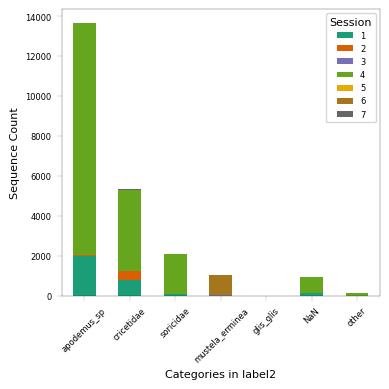

In [109]:
# Plot available Sequences per Label
########################################################################################################################
fig_name = "label2_session.pdf"
fig_size = (10*cm,10*cm)
########################################################################################################################

label_files = paths['labels'].glob('*.csv')

df = pd.DataFrame()

for file in label_files:
    df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
)

ax.set_xlabel("Categories in label2")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()

if save_fig_path is not None:
    plt.savefig(save_fig_path / fig_name, dpi=300)

plt.show()


In [3]:
dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:236: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(
/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:236: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


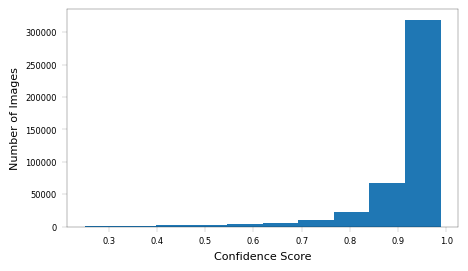

In [ ]:
# Plot Histogram of Detection Confidence Scores
########################################################################################################################
fig_name = 'detection_conf_hist.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

df = dataset_img.ds

plt.figure(figsize=fig_size)
plt.hist(df['conf'], bins=10)
plt.xlabel('Confidence Score')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

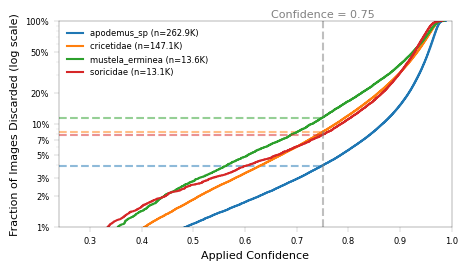

In [ ]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.75
########################################################################################################################

df = dataset_img.ds

cdf_data = (
    df.sort_values(by='conf')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf': np.sort(g['conf'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf'], group['cum_density'], label=label)

    above_thresh = group[group['conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(frameon=False)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.01, top=1)
plt.tight_layout()
plt.show()

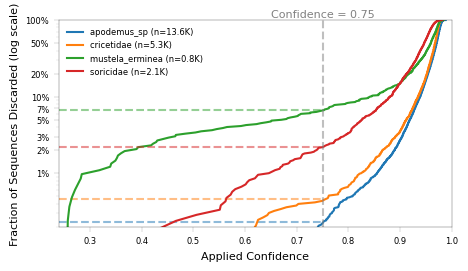

In [ ]:
# Plot Fraction of Discarded Sequences by Applied Confidence
########################################################################################################################
fig_name = 'discarded_seq_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.75
########################################################################################################################

seq_class_conf = (
    df.groupby(['class_label', 'seq_id'])['conf']
      .max()
      .reset_index(name='max_conf')
)
cdf_parts = []

for class_label, group in seq_class_conf.groupby('class_label'):
    conf_sorted = np.sort(group['max_conf'].to_numpy())
    cum_density = np.linspace(0, 1, len(conf_sorted))

    part_df = pd.DataFrame({
        'class_label': class_label,
        'max_conf': conf_sorted,
        'cum_density': cum_density
    })

    cdf_parts.append(part_df)

cdf_seq = pd.concat(cdf_parts, ignore_index=True)

seq_counts = seq_class_conf['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_seq.groupby('class_label'):
    count = seq_counts.get(class_label, 0)
    label = f"{class_label} (n={count/1000:.1f}K)"
    
    line, = plt.plot(group['max_conf'], group['cum_density'], label=label)

    # Horizontal marker at the confidence threshold
    above_thresh = group[group['max_conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

# Global reference lines
plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

# Axes styling
plt.xlabel("Applied Confidence")
plt.ylabel("Fraction of Sequences Discarded (log scale)")
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1],
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(frameon=False)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.002, top=1)
plt.tight_layout()
plt.show()

In [4]:
dataset_seq.get_bb_list_for_seq(seq_id=4018688)

{'file': ['IMG_4270.JPG', 'IMG_4271.JPG', 'IMG_4272.JPG'],
 'bbox': [[0.6201, 0.6126, 0.2275, 0.1549],
  [0.2734, 0.5709, 0.1904, 0.0618],
  [0.2021, 0.5651, 0.1269, 0.0605]],
 'conf': [0.946, 0.857, 0.699]}

In [5]:
dataset_seq.get_all_images_of_sequence(seq_id=4018688)

{'IMG_4270.JPG': PosixPath('/cfs/earth/scratch/kraftjul/BA/data/dataset/sessions/session_04/W7-WK06/IMG_4270.JPG'),
 'IMG_4271.JPG': PosixPath('/cfs/earth/scratch/kraftjul/BA/data/dataset/sessions/session_04/W7-WK06/IMG_4271.JPG'),
 'IMG_4272.JPG': PosixPath('/cfs/earth/scratch/kraftjul/BA/data/dataset/sessions/session_04/W7-WK06/IMG_4272.JPG')}

In [8]:
i = dataset_seq.get_index_by_seq_id(4018688)
sample = dataset_seq[i]

IndexError: single positional indexer is out-of-bounds

In [133]:
seq_id = 4018688

# All indices in the dataset where this seq_id appears
indices = dataset_seq.ds.index[dataset_seq.ds['seq_id'] == seq_id].tolist()

for i in indices:
    sample = dataset_seq[i]  # should now work
    print(sample['file_path'])  # or whatever you're extracting

IndexError: list index out of range

In [131]:
len(dataset_seq.ds.index.tolist())


21831

In [132]:
len(dataset_seq.ds)

21831

In [115]:
dataset_seq.ds[dataset_seq.ds['seq_id'] == 4018688]

,session,SerialNumber,seq_nr,seq_id,Directory,DateTime_start,DateTime_end,duration_seconds,first_file,last_file,n_files,all_files,class_label,class_id
23230,4,H550HF08161368,239,4018688,sessions/session_04/W7-WK06,2020-07-18T07:47:46Z,2020-07-18T07:47:48Z,2.0,IMG_4270.JPG,IMG_4272.JPG,3,"IMG_4270.JPG,IMG_4271.JPG,IMG_4272.JPG",soricidae,3


In [ ]:
interessting_sequences = [23230]

In [124]:
seq_id = 4018688

# All indices in the dataset where this seq_id appears
indices = dataset_seq.ds.index[dataset_seq.ds['seq_id'] == seq_id].tolist()

indices

[23230]

Randomly selected index: 243289


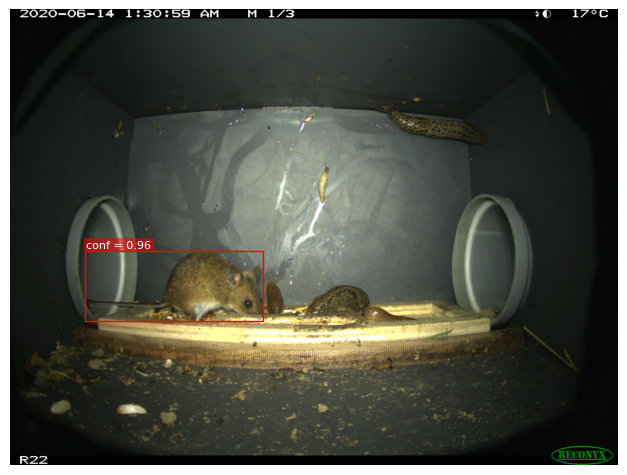

In [11]:
i = randint(0, len(dataset_img) - 1)
print(f"Randomly selected index: {i}")
sample = dataset_img[i]

fig = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
display(fig)

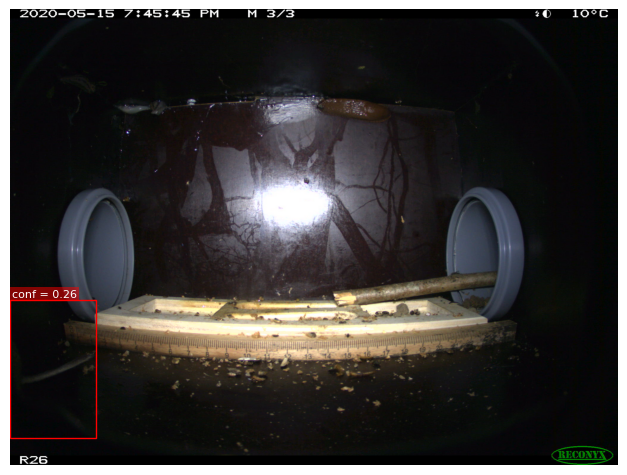

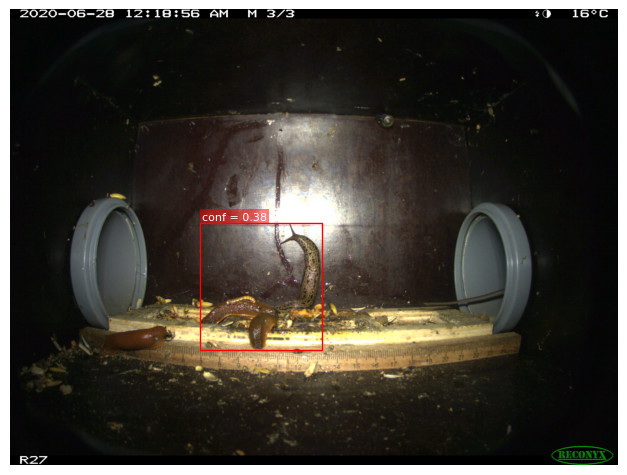

In [112]:
interesting_images = [108812, 340523]

for i in interesting_images:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)

In [ ]:
# lowest_conf_indices = dataset_img.ds.nsmallest(5, 'conf').index.tolist()

# for i in lowest_conf_indices:
#     sample = dataset_img[i]
#     figure = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
#     display(figure)
    